## Tutorial 1: Using pyMOR’s discretization toolkit

pyMOR’s discretization toolkit allows to quickly build parametrized full
order models based on the NumPy/SciPy software stack. Currently
supported are stationary or instationary scalar PDEs of up to second
order with possibly nonlinear advection or reaction terms in one or two
spatial dimensions. Unstructured meshes can be imported in the Gmsh file
format.

In this tutorial we will focus on elliptic equations of the form

$$
-\nabla \cdot \big(\sigma(x, \mu) \nabla u(x, \mu) \big) = f(x, \mu),\quad x \in \Omega,
$$

on the domain $\Omega:= (0, 1)^2 \subset \mathbb{R}^2$ with data
functions $f(\cdot, \mu) \in L^2(\Omega)$,
$\sigma(\cdot, \mu) \in L^\infty(\Omega)$.

### A first equation without parameters

First, let us assume that the source $f(x, \mu)$ is an indicator
function of a circular disk with radius $0.3$ and that
$\sigma(x, \mu)$ is constant:

$$
f(x, \mu) :=
\begin{cases}
   1 & |x - (0.5, 0.5)| < 0.3\\
   0 & \text{otherwise}.
\end{cases} \quad\text{and}\quad
\sigma(x,\mu) :\equiv 1
$$

We start by importing commonly used pyMOR classes and methods from the
[basic](./generated/pymor.html#module-pymor.basic) module:

In [1]:
from pymor.basic import *

To specify the problem at hand using pyMOR’s discretization toolkit, we
first need to specify the computational domain $\Omega$. Multiple
classes are available to define such domains in
in the [domaindescriptions](./generated/pymor.analyticalproblems.html#module-pymor.analyticalproblems.domaindescriptions) module,
which all derive from the [DomainDescription](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.domaindescriptions.DomainDescription) interface class.

In our case, we can use a [RectDomain](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.domaindescriptions.RectDomain):

In [2]:
domain = RectDomain([[0.,0.], [1.,1.]])

Data functions are defined using classes which derive from
the [Function](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.Function) interface. We specify the constant diffusivity $\sigma$
using a [ConstantFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.ConstantFunction):

In [3]:
diffusion = ConstantFunction(1, 2)

Here, the first argument is the function’s constant value. The second
argument is the spatial dimension of the domain the problem is defined
on.

For the definition of the source term $f$ we use an
[ExpressionFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.ExpressionFunction) which is given an arbitrary Python expression
used to evaluate the function. In this expression, the coordinates at
which the function shall be evaluated are given as the variable `x`.
Many NumPy functions can be used directly. The entire NumPy module is
available under the name `np`.

Thus, to define $f$ we could write

```
(sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2) <= 0.3) * 1.
```

However, pyMOR [Functions](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.Function) are required to be vectorized with respect
to the coordinate `x`. In the case of [ExpressionFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.ExpressionFunction) this
means that `x` can be an arbitrary dimensional NumPy array of
coordinates where the last array index specifies the spacial dimension.
Therefore, the correct definition of $f$ is:

In [4]:
rhs = ExpressionFunction('(sqrt( (x[...,0]-0.5)**2 + (x[...,1]-0.5)**2) <= 0.3) * 1.', 2, ())

Similarly to [ConstantFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.ConstantFunction), the second argument is the dimension
of the computational domain. As the shape of the return value cannot be
easily inferred from the given string expression, it has to be provided
as a third argument to [ConstantFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.ConstantFunction). For scalar functions we
provide the empty tuple `()`, for functions returning
three-dimensional vectors we would specify `(3,)`, and for functions
returning $2\times 2$ matrices we would specify `(2,2)`.

Finally, the computational domain and all data functions are collected
in a [StationaryProblem](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.elliptic.StationaryProblem):

In [5]:
problem = StationaryProblem(
    domain=domain,
    diffusion=diffusion,
    rhs=rhs,
)

This problem definition can now be handed over to discretization methods
(see [pymor.discretizers.builtin](./generated/pymor.discretizers.builtin.html#module-pymor.discretizers.builtin)) which assemble corresponding
discrete full order models. For finite elements, we use
[discretize_stationary_cg](./generated/pymor.discretizers.builtin.html#pymor.discretizers.builtin.cg.discretize_stationary_cg),
which receives the maximum mesh element diameter via the `diameter`
argument:

In [6]:
m, data = discretize_stationary_cg(problem, diameter=1/4)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

The resulting [Model](./generated/pymor.models.html#pymor.models.interface.Model) can be [solved](./generated/pymor.models.html#pymor.models.interface.Model.solve),
returning a [VectorArray](./generated/pymor.vectorarrays.html#pymor.vectorarrays.interface.VectorArray) with the solution data:

In [7]:
U = m.solve()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Finally, we visualize the solution:

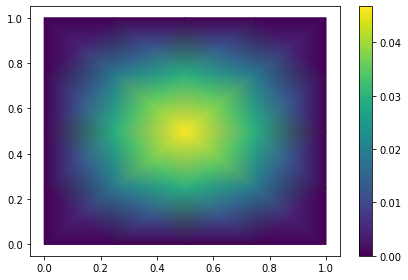

In [8]:
m.visualize(U)

In case a specific grid type shall be used ([RectGrid](./generated/pymor.discretizers.builtin.grids.html#pymor.discretizers.builtin.grids.rect.RectGrid) or
[TriaGrid](./generated/pymor.discretizers.builtin.grids.html#pymor.discretizers.builtin.grids.tria.TriaGrid)), the corresponding class has to be passed to the
discretizer as the `grid_type` argument. By using [RectGrid](./generated/pymor.discretizers.builtin.grids.html#pymor.discretizers.builtin.grids.rect.RectGrid) we get
bilinear finite elements:

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

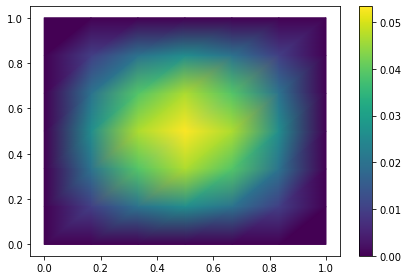

In [9]:
m, data = discretize_stationary_cg(problem, diameter=1/4, grid_type=RectGrid)
m.visualize(m.solve())

We get a finite volume model using
[discretize_stationary_fv](./generated/pymor.discretizers.builtin.html#pymor.discretizers.builtin.fv.discretize_stationary_fv):

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

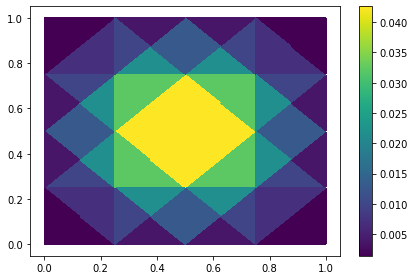

In [10]:
m, data = discretize_stationary_fv(problem, diameter=1/4, grid_type=TriaGrid)
m.visualize(m.solve())

# Defining boundary conditions

As the vigilant reader will already have noticed, we did not specify any
boundary conditions when defining and solving our problem. When no
boundary conditions are specified, pyMOR’s discretization toolkit will
assume that homogeneous Dirichlet conditions are implied over the entire
boundary of $\Omega$.

As a the next example, let us now assume that the data functions are
given by

$$
f(x,\mu) \equiv 0 \quad\text{and}\quad
\sigma(x, \mu) :=
\begin{cases}
   0.001 & |x - (0.5, 0.5)| < 0.3\\
   1 & \text{otherwise,}
\end{cases}
$$

and that we have the following mixed boundary conditions

$$
\begin{align}
- \sigma_(x, \mu) \nabla u(x, \mu) \cdot n &= g_N(x), &&x \in (0,1) \times \{0\} =: \Omega_N \\
u(x, \mu) &= 0, &&x \in \partial\Omega \setminus \Omega_N,
\end{align}
$$

with $g_N(x) \equiv -1$.

Before solving this problem, let us first silence pyMOR’s verbose log
messages for the rest of this tutorial using the [set_log_levels](./generated/pymor.core.html#pymor.core.logger.set_log_levels)
method:

In [11]:
set_log_levels({'pymor': 'WARN'})

To impose the right boundary conditions we need to declare which type of
boundary condition should be active on which part of
$\partial\Omega$ when defining the computational domain:

In [12]:
domain = RectDomain(bottom='neumann')

Then all we need to pass the Neumann data function $g_N$ to the
[StationaryProblem](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.elliptic.StationaryProblem). Here, we can use again a [ConstantFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.ConstantFunction).
The diffusivity can be defined similarly as above:

In [13]:
neumann_data = ConstantFunction(-1., 2)

diffusion = ExpressionFunction('1. - (sqrt( (x[...,0]-0.5)**2 + (x[...,1]-0.5)**2) <= 0.3) * 0.999' , 2, ())

problem = StationaryProblem(
    domain=domain,
    diffusion=diffusion,
    neumann_data=neumann_data
)

Finally, we discretize and solve:

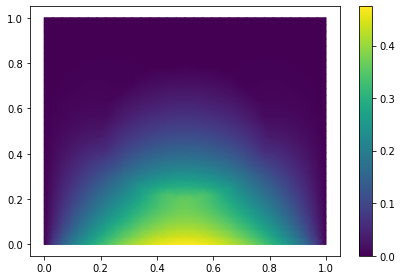

In [14]:
m, data = discretize_stationary_cg(problem, diameter=1/32)
m.visualize(m.solve())

# Another example

Even with a single [ExpressionFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.ExpressionFunction) we can build many different examples.
For instance, to let $\sigma$ be given by a periodic pattern of
$K\times K$ circular disks of radius $0.3/K$ we can use the
following definition:

In [15]:
diffusion = ExpressionFunction(
    '1. - (sqrt( (np.mod(x[...,0],1./K)-0.5/K)**2 + (np.mod(x[...,1],1./K)-0.5/K)**2) <= 0.3/K) * 0.999',
    2, (),
    values={'K': 10}
)

Here, we have used the `values` parameter of [ExpressionFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.ExpressionFunction) to
make `K` available as an additional constant in the defining
expression. In particular, we can easily change `K` programatically
without having to resort to string manipulations. The solution looks
like this:

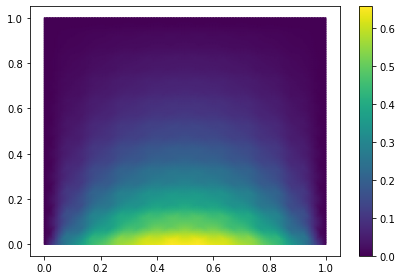

In [16]:
problem = StationaryProblem(
    domain=domain,
    diffusion=diffusion,
    neumann_data=neumann_data
)


m, data = discretize_stationary_cg(problem, diameter=1/100)
m.visualize(m.solve())

# Data functions defined from pixel graphics

[BitmapFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.BitmapFunction) uses the Python Imaging Library (PIL) to read gray
scale images in various image file formats. The resulting
two-dimensional NumPy array of pixel values defines a piecewise constant
data function on a rectangular domain, where the range of the function
(from black to white) is specified via the `range` parameter. For
instance, when using a [BitmapFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.BitmapFunction) for $\sigma$ with the
following graphic stored in `RB.png`:

![](_images/RB.png)and a range of `[0.001 1]` we obtain:

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

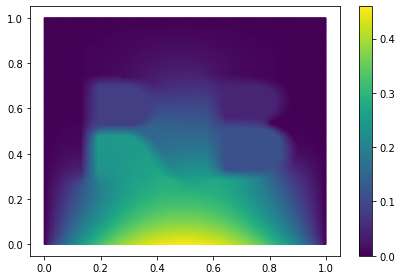

In [17]:
diffusion = BitmapFunction('RB.png', range=[0.001, 1])
problem = StationaryProblem(
    domain=domain,
    diffusion=diffusion,
    neumann_data=neumann_data
)

m, data = discretize_stationary_cg(problem, diameter=1/100)
m.visualize(m.solve())

The displayed warning results from the fact that the used image file has
an additinal channel of transparancy values (alpha channel) and can be
ignored.

# A parametric problem

Now, let us consider the Neumann data function:

$$
g_N((x_0, x_1), \mu_{neum}) := -\cos(\pi \cdot x_0)^2 \cdot\mu_{neum}
$$

with a single [Parameter](./generated/pymor.parameters.html#pymor.parameters.base.Parameters) $\mu_{neum} \in \mathbb{R}$.

In pyMOR, [parameter values](./generated/pymor.parameters.html#pymor.parameters.base.Mu) are specified as a dictionary of one-dimensional
[NumPy arrays](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html#numpy.ndarray). Each value in the dictionary must have a correct size specified by the
[Parameters](./generated/pymor.parameters.html#pymor.parameters.base.Parameters) of the [ParametricObject](./generated/pymor.parameters.html#pymor.parameters.base.ParametricObject). In this example we have a single scalar
valued parameter which we call `'neum'`. Thus, the [Parameters](./generated/pymor.parameters.html#pymor.parameters.base.Parameters) of the function
will be

```
{'neum': 1}
```

We can then make the following definition of the Neumann data:

In [18]:
neumann_data = ExpressionFunction('-cos(pi*x[...,0])**2*neum[0]', 2, (), parameters= {'neum': 1})

Similar to the range of the function, pyMOR cannot infer from the given
string expression the parameters used in the expression, so these
[Parameters](./generated/pymor.parameters.html#pymor.parameters.base.Parameters) have to be provided as the `parameters` argument.
The individual parameters are then available as variables in
the expression.

We can then proceed as usual and automatically obtain a parametric
[Model](./generated/pymor.models.html#pymor.models.interface.Model):

In [19]:
diffusion = ExpressionFunction(
    '1. - (sqrt( (np.mod(x[...,0],1./K)-0.5/K)**2 + (np.mod(x[...,1],1./K)-0.5/K)**2) <= 0.3/K) * 0.999',
    2, (),
    values={'K': 10}
)
problem = StationaryProblem(
    domain=domain,
    diffusion=diffusion,
    neumann_data=neumann_data
)

m, data = discretize_stationary_cg(problem, diameter=1/100)
m.parameters

Parameters({neum: 1})

When solving the model, we now need to specify appropriate
[parameter values](./generated/pymor.parameters.html#pymor.parameters.base.Mu):

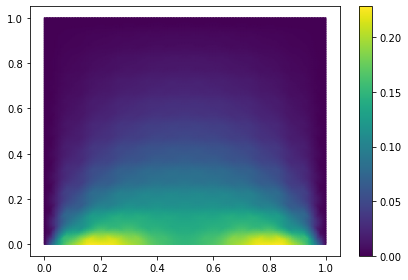

In [20]:
m.visualize(m.solve({'neum': [1.]}))

For the [solve](./generated/pymor.models.html#pymor.models.interface.Model.solve) method, the
parameter value can also be specified as a single number:

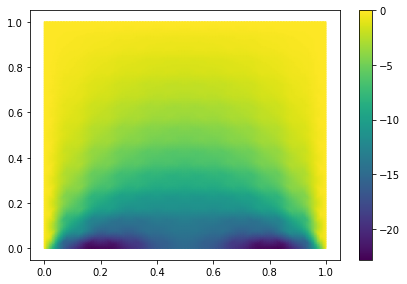

In [21]:
m.visualize(m.solve(-100))

# Multiple parameters

Next we also want to to parametrize the diffusivity in the
$K \times K$ circular disks by a scalar factor
$\mu_{diffu}$. To this end we define:

In [22]:
diffusion = ExpressionFunction(
    '1. - (sqrt( (np.mod(x[...,0],1./K)-0.5/K)**2 + (np.mod(x[...,1],1./K)-0.5/K)**2) <= 0.3/K) * (1 - diffu[0])',
    2, (),
    values={'K': 10},
    parameters= {'diffu': 1}
)

We proceed as usual:

In [23]:
problem = StationaryProblem(
    domain=domain,
    diffusion=diffusion,
    neumann_data=neumann_data
)

m, data = discretize_stationary_cg(problem, diameter=1/100)
m.parameters

Parameters({diffu: 1, neum: 1})

As we can see, pyMOR automatically derives that in this case the model
depends on two [Parameters](./generated/pymor.parameters.html#pymor.parameters.base.Parameters), and we have to provide two values
when solving the model:

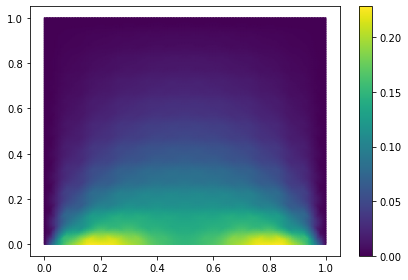

In [24]:
m.visualize(m.solve({'diffu': 0.001, 'neum': 1}))

For [solve](./generated/pymor.models.html#pymor.models.interface.Model.solve) we can also
simply pass a list of parameter values, in which case
pyMOR assumes an alphabetical ordering of the parameters:

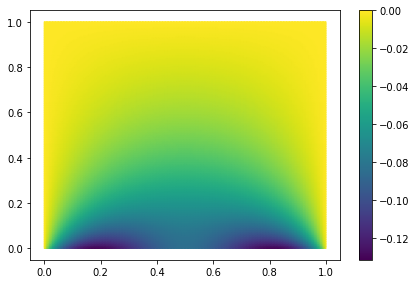

In [25]:
m.visualize(m.solve([1, -1]))

# Parameter-separability

For the generation of online-efficient reduced order models, it is often
crucial that data functions are parameter separable. We call a
parametric function `f(x, mu)` parameter separable if it admits a
decomposition

$$
f(x, \mu) = \sum_{q=1}^Q f_q(x) \cdot \theta_q(\mu)
$$

where the $f_q$ are non-parametric and the *parameter
functionals* $\theta_q$ map parameters to real numbers.

To model such a decomposition using pyMOR’s discretization toolkit, we
specify the $f_q$ as non-parametric [Functions](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.Function), the
$\theta_q$ are represented by [ParameterFunctionals](./generated/pymor.parameters.html#pymor.parameters.functionals.ParameterFunctional) and the
given sum decomposition is represented by a [LincombFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.LincombFunction) of these
objects.

As an example let us go back to the case where the diffusivity is
represented by indicator functions of point sets forming the letters
`RB`. We now want to parametrize the diffusivity in the individual
letters. This admits a decomposition of the form

$$
\sigma(x,y) = 1 + f_R \cdot (\mu_R - 1) + f_B \cdot (\mu_L - 1)
$$

Again, we define $f_R$ and $f_L$ as [BitmapFunctions](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.BitmapFunction) for
the following image files:

![](_images/R.png)![](_images/B.png)

In [26]:
f_R = BitmapFunction('R.png', range=[1, 0])
f_B = BitmapFunction('B.png', range=[1, 0])

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Next we need to define the [ParameterFunctionals](./generated/pymor.parameters.html#pymor.parameters.functionals.ParameterFunctional)

$$
\theta_R(\mu) = \mu_R - 1 \quad\text{and}\quad \theta_B(\mu) = \mu_B - 1.
$$

Similar to an [ExpressionFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.ExpressionFunction), we can use
[ExpressionParameterFunctionals](./generated/pymor.parameters.html#pymor.parameters.functionals.ExpressionParameterFunctional) for that:

In [27]:
theta_R = ExpressionParameterFunctional('R[0] - 1', {'R': 1})
theta_B = ExpressionParameterFunctional('B[0] - 1', {'B': 1})

Note that the second argument is again the [Parameters](./generated/pymor.parameters.html#pymor.parameters.base.Parameters)
that are used in the expression. Finally, we form the linear
combination using a [LincombFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.LincombFunction) which is given a list of
[Functions](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.Function) as the first and a corresponding list of
[ParameterFunctionals](./generated/pymor.parameters.html#pymor.parameters.functionals.ParameterFunctional) or constants as the second argument:

In [28]:
diffusion = LincombFunction(
    [ConstantFunction(1., 2), f_R, f_B],
    [1., theta_R, theta_B]
)
diffusion.parameters

Parameters({B: 1, R: 1})

Again, pyMOR automatically derives that the evaluation of `diffusion`
depends on the two [Parameters](./generated/pymor.parameters.html#pymor.parameters.base.Parameters) `'B'` and `'R'`. Now, we can
proceed as usual:

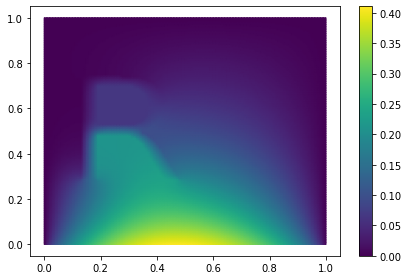

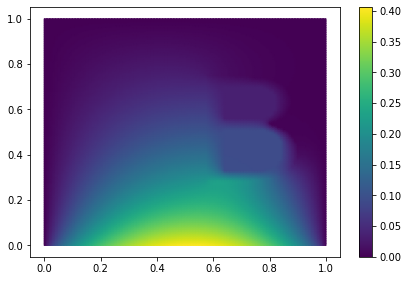

In [29]:
problem = StationaryProblem(
    domain=domain,
    diffusion=diffusion,
    neumann_data=ConstantFunction(-1, 2)
)
m, data = discretize_stationary_cg(problem, diameter=1/100)
m.visualize(m.solve([1., 0.001]))
m.visualize(m.solve([0.001, 1]))

Looking at the [Model](./generated/pymor.models.html#pymor.models.interface.Model) `m`, we can see that the decomposition of
$\sigma$ has been preserved by the discretizer:

In [30]:
m.operator

LincombOperator(
    (NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='boundary_part'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_0'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_1'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_2')),
    (1.0, 1.0, ExpressionParameterFunctional('R[0] - 1', {R: 1}), ExpressionParameterFunctional('B[0] - 1', {B: 1})),
    name='ellipticOperator')

The [LincombFunction](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.LincombFunction) has become a [LincombOperator](./generated/pymor.operators.html#pymor.operators.constructions.LincombOperator), with the same
linear coefficients but the [BitmapFunctions](./generated/pymor.analyticalproblems.html#pymor.analyticalproblems.functions.BitmapFunction) replaced by
corresponding stiffness matrices. Note that an additional summand
appears which ensures correct enforcement of Dirichlet boundary values
for all possible parameter value combinations.